In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler


In [2]:
df_wine = pd.read_csv("data/wine-reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df_wine.head()


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
df_diabetes = pd.read_csv("data/diabetes.csv")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


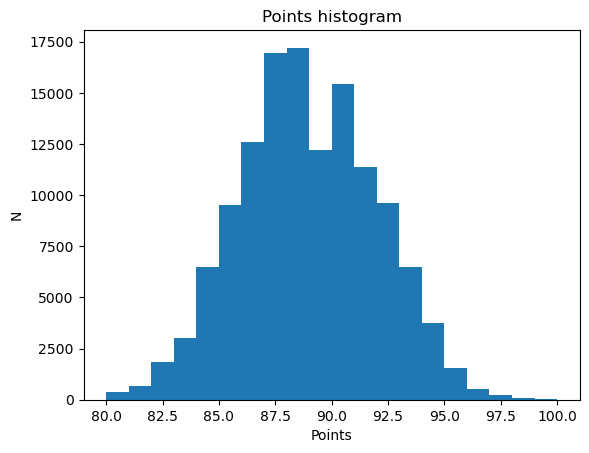

In [4]:
plt.hist(df_wine.points, bins=20)
plt.title("Points histogram")
plt.xlabel("Points")
plt.ylabel("N")
plt.show()

In [5]:
df_wine["label"] = (df_wine.points >= 90).astype(int)
df_wine = df_wine[["description", "label"]]
df_wine.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [6]:
train, valid, test = np.split(df_wine.sample(frac=1), [int(0.8*len(df_wine)), int(0.9*len(df_wine))])

In [7]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds
    

In [8]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

In [9]:
list(train_data)[0]

(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b"Crisp pears and apples abound in this light-bodied dry Riesling. It's delicate in concentration but pleasantly lemony. The wine finishes briskly but freshly.",
        b'This has orange, pineapple and green apple flavors that are accented by oaky caramel. Balanced with crisp, citrusy acidity, this should pair well with rich shellfish fare. Drink now.',
        b"Roasted beef and bacon fat scents meet with maple, char, Concord grape and blueberry on the nose of this hearty bottling from a winery recently acquired by O'Neill Vintners. Its tannins are deep and firm but welcoming, providing the framework for black currant, blueberry, charred beef and rosemary flavors.",
        b"Aromas like fresh flowers and rosemary lead to lively citrus flavors and a dry balance that makes this wine more serious than many of its peers. Light to medium bodied and brisk with acidity, it's very thirst-quenching.",
        b'88-90 Barrel sample. There

In [10]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)


In [11]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 0.37717497, -0.04858768,  0.08667555, ..., -0.19379708,
         0.0346763 ,  0.01618387],
       [ 0.25986502, -0.2841725 , -0.12060685, ...,  0.2214437 ,
        -0.11724945, -0.02968322],
       [ 0.1858289 , -0.31372356, -0.06876764, ...,  0.19311912,
        -0.32015327,  0.21082635],
       ...,
       [ 0.6057074 ,  0.147544  ,  0.12139387, ...,  0.1507542 ,
        -0.21344107, -0.00417345],
       [ 0.39723477, -0.40856797, -0.00262472, ...,  0.26196373,
        -0.09823929,  0.00349052],
       [ 0.25212464, -0.32116878,  0.14616315, ..., -0.02970742,
         0.00813293, -0.0698135 ]], dtype=float32)>

In [12]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [14]:
model.evaluate(train_data)

3250/3250 [==============================] - 3s 792us/step - loss: 0.6966 - accuracy: 0.4769


[0.6966198086738586, 0.4769465923309326]

In [15]:
model.evaluate(valid_data)

407/407 [==============================] - 0s 828us/step - loss: 0.6976 - accuracy: 0.4703


[0.6976104974746704, 0.4702623784542084]

In [16]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
3250/3250 [==============================] - 791s 243ms/step - loss: 0.4028 - accuracy: 0.8105 - val_loss: 0.3592 - val_accuracy: 0.8346
Epoch 2/5
3250/3250 [==============================] - 794s 244ms/step - loss: 0.3215 - accuracy: 0.8570 - val_loss: 0.3505 - val_accuracy: 0.8391
Epoch 3/5
3250/3250 [==============================] - 786s 242ms/step - loss: 0.2796 - accuracy: 0.8788 - val_loss: 0.3600 - val_accuracy: 0.8383
Epoch 4/5
3250/3250 [==============================] - 780s 240ms/step - loss: 0.2293 - accuracy: 0.9040 - val_loss: 0.3955 - val_accuracy: 0.8367
Epoch 5/5
3250/3250 [==============================] - 781s 240ms/step - loss: 0.1787 - accuracy: 0.9276 - val_loss: 0.4494 - val_accuracy: 0.8347


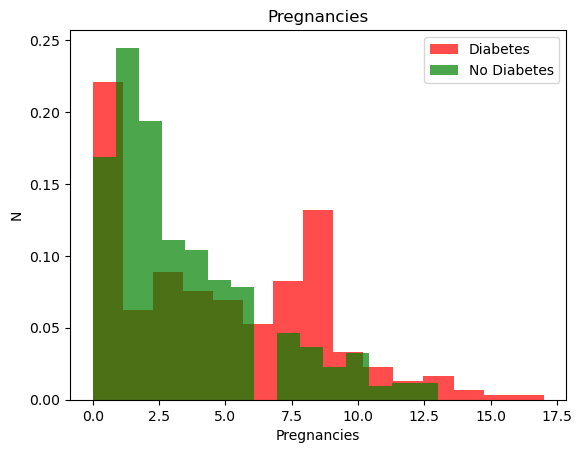

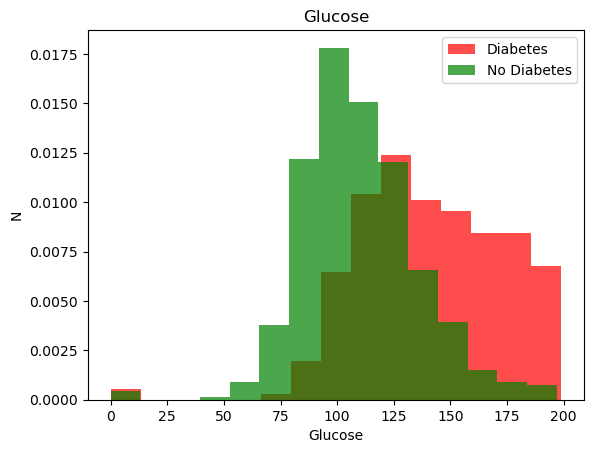

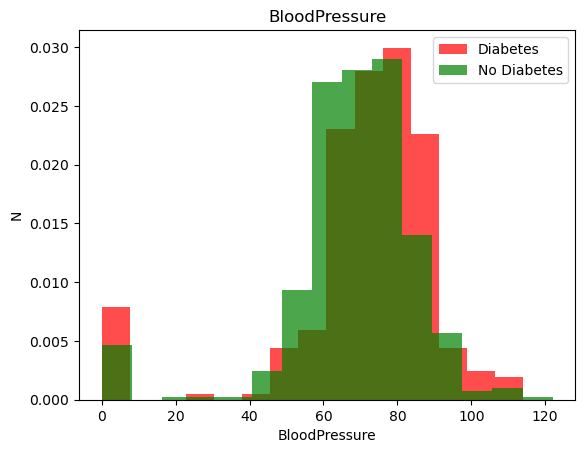

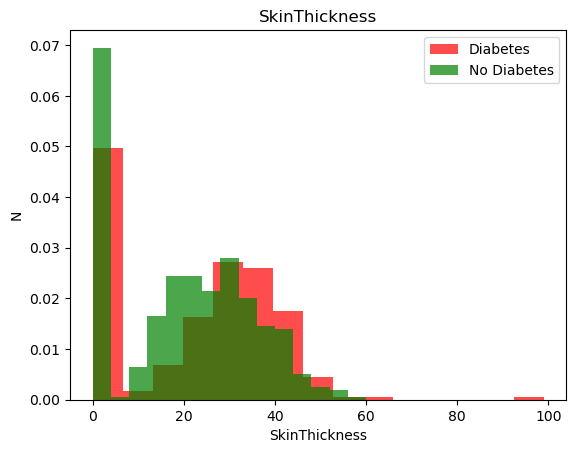

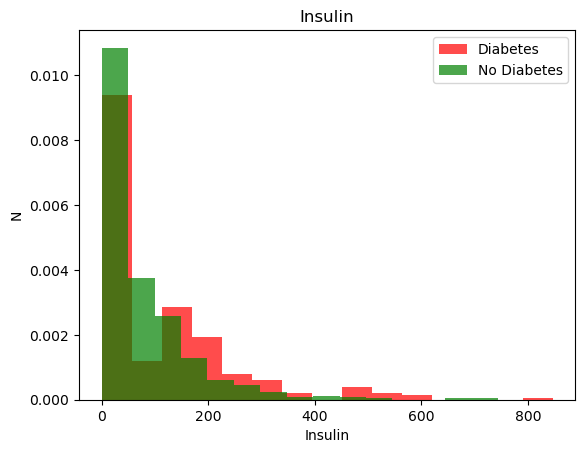

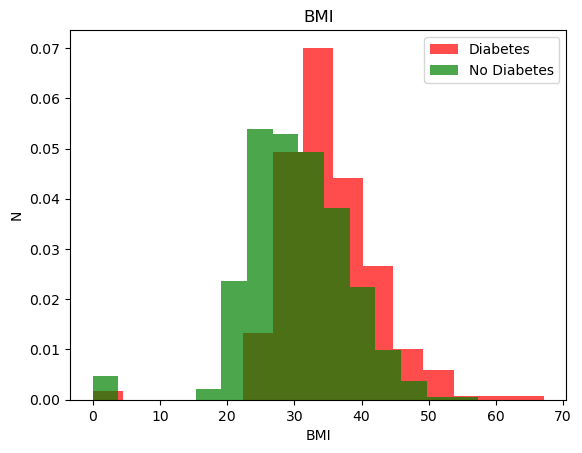

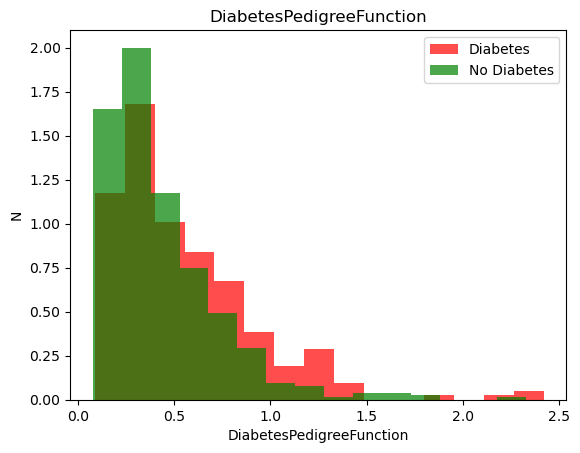

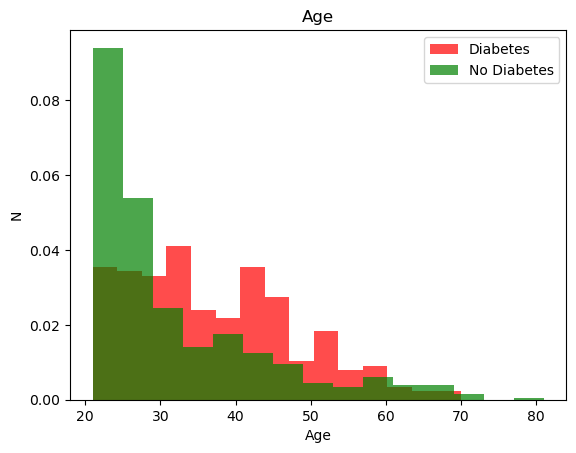

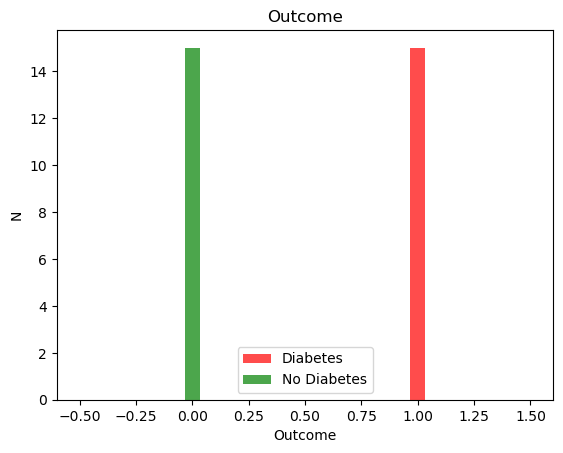

IndexError: index 9 is out of bounds for axis 0 with size 9

In [41]:
for i in range(len(df_diabetes[:-1])):
    label = df_diabetes.columns[i]
    plt.hist(df_diabetes[df_diabetes['Outcome']==1][label], color='red', label='Diabetes', alpha=0.7, density=True, bins=15)
    plt.hist(df_diabetes[df_diabetes['Outcome']==0][label], color='green', label='No Diabetes', alpha=0.7, density=True, bins=15)
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('N')
    plt.legend()
    plt.show()

In [ ]:
X = df_diabetes[df_diabetes.columns[:-1]].values
y = df_diabetes[df_diabetes.columns[-1]].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=df_diabetes.columns)

In [ ]:
len(transformed_df[transformed_df['Outcome']==1]), len(transformed_df[transformed_df['Outcome']==0])

(268, 500)

In [ ]:
over = RandomOverSampler()
X, y = over.fit_resample(X, y)
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=df_diabetes.columns)


In [ ]:
len(transformed_df[transformed_df['Outcome']==1]), len(transformed_df[transformed_df['Outcome']==0])

(500, 500)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(X_train, y_train)

19/19 [==============================] - 0s 999us/step - loss: 0.7495 - accuracy: 0.3883


[0.7494762539863586, 0.3883333206176758]

In [ ]:
model.evaluate(X_valid, y_valid)

16/16 [==============================] - 0s 604us/step - loss: 0.7478 - accuracy: 0.4020


[0.7477594017982483, 0.4020000100135803]

In [ ]:
model.fit(X_train, y_train, batch_size=16, epochs=32, validation_data=(X_valid, y_valid))

Epoch 1/32
38/38 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6583 - val_loss: 0.6464 - val_accuracy: 0.6680
Epoch 2/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6470 - accuracy: 0.6583 - val_loss: 0.6451 - val_accuracy: 0.6680
Epoch 3/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.6600 - val_loss: 0.6438 - val_accuracy: 0.6760
Epoch 4/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6444 - accuracy: 0.6667 - val_loss: 0.6425 - val_accuracy: 0.6740
Epoch 5/32
38/38 [==============================] - 0s 1ms/step - loss: 0.6431 - accuracy: 0.6667 - val_loss: 0.6413 - val_accuracy: 0.6760
Epoch 6/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6667 - val_loss: 0.6401 - val_accuracy: 0.6780
Epoch 7/32
38/38 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.6683 - val_loss: 0.6389 - val_accuracy: 0.6800
Epoch 8/32
38/38 [==

In [ ]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 733us/step - loss: 0.6376 - accuracy: 0.6360


[0.6375736594200134, 0.6359999775886536]